## imports

In [1]:
%load_ext autoreload
%autoreload 2


from tqdm.auto import tqdm
import numpy as np
import pandas as pd 
import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import datetime as dtm
import matplotlib.pyplot as plt
import seaborn as sns
import gc


! pip install catboost

import catboost
from catboost import Pool, CatBoostClassifier, CatBoostRegressor

## Data preparation

Max private score: 0.569, max open: 0.4695

I used the catboost classifiers ensemble for all my solutions. All the difference has been achieved during feature engineering and hyperparameter search.

Test scoring is very unstable and private part doesn't correlate with open part at all. So it was practically impossible to choose the best solution here. 
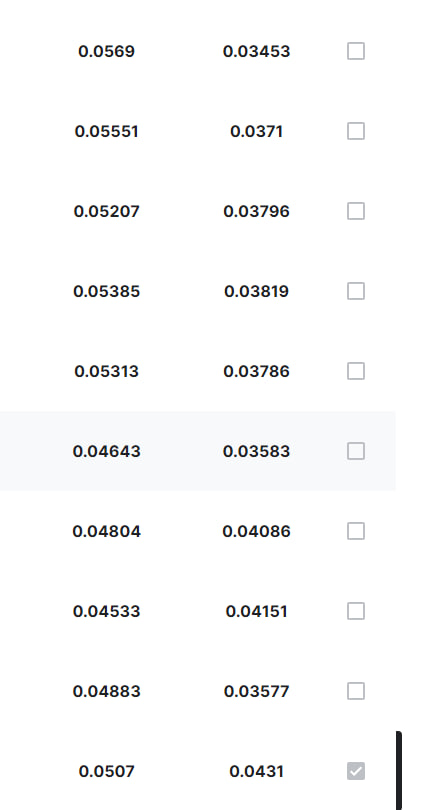
 

In [2]:
def gini_score(y_true, y_pred):
    return 2 * roc_auc_score(y_true, y_pred) - 1

In [3]:
train_df = pd.read_csv('../input/uplift-shift-23/x5-uplift-valid/data/train.csv')
test_df = pd.read_csv('../input/uplift-shift-23/x5-uplift-valid/data/test.csv')
clients_info_df = pd.read_csv('../input/uplift-shift-23/x5-uplift-valid/data/clients2.csv')
products_info_df = pd.read_csv('../input/uplift-shift-23/x5-uplift-valid/data/products.csv')

In [4]:
train_purch_df = pd.read_csv('../input/uplift-shift-23/x5-uplift-valid/train_purch/train_purch.csv')
test_purch_df = pd.read_csv('../input/uplift-shift-23/x5-uplift-valid/test_purch/test_purch.csv')

In [5]:
clients_info_df.set_index('client_id', inplace=True)
products_info_df.set_index('product_id', inplace=True)

# prepare categorical features for use in catboost model
products_info_df['segment_id'] = products_info_df['segment_id'].fillna(0).astype(int)
products_info_df['brand_id'] = products_info_df['brand_id'].fillna('UNK').astype(str)
products_info_df['vendor_id'] = products_info_df['vendor_id'].fillna('UNK').astype(str)

# beautiful target expression instead of million 'if's
train_df['target'] = train_df.treatment_flg ^ train_df.purchased ^ 1

# push clients info in dataset
train_dataset = pd.merge(train_df, clients_info_df, on='client_id', how='left').drop(columns=['treatment_flg', 'purchased', 'client_id.1']).set_index('client_id')
test_dataset = pd.merge(test_df, clients_info_df, on='client_id', how='left').drop(columns='client_id.1').set_index('client_id')

train_df.set_index('client_id', inplace=True)
# test_df.set_index('client_id', inplace=True)

In [6]:
# extract transaction date
train_purch_df['transaction_date'] = pd.to_datetime(train_purch_df['transaction_datetime']).dt.date
test_purch_df['transaction_date'] = pd.to_datetime(test_purch_df['transaction_datetime']).dt.date

# prepare for use in catboost again
train_purch_df['store_id'] = train_purch_df['store_id'].fillna('UNK').astype(str)
test_purch_df['store_id'] = test_purch_df['store_id'].fillna('UNK').astype(str)

# glue products info to the purchase dataframe for easier use in future
train_purch_df = train_purch_df.join(products_info_df, on='product_id')
test_purch_df = test_purch_df.join(products_info_df, on='product_id')

In [7]:
# we probably can use the time of the day later 
train_purch_df['transaction_time'] = pd.to_timedelta(pd.to_datetime(train_purch_df['transaction_datetime']).dt.time.astype(str)).dt.total_seconds()
test_purch_df['transaction_time'] = pd.to_timedelta(pd.to_datetime(test_purch_df['transaction_datetime']).dt.time.astype(str)).dt.total_seconds()

In [8]:
train_df.head()

,treatment_flg,purchased,target
client_id,,,
ad6561e2d8,1,1,1
7c1ccbf93f,1,1,1
b58fadcab6,1,1,1
e99e6fabb9,0,0,1
27fb6f8520,1,1,1


In [9]:
test_df.head()

,client_id
0,a9a604ed6e
1,ebd7360016
2,908cd9b8e8
3,dceb8ce861
4,f4f0ac6b06


In [10]:
clients_info_df.head()

,client_id.1,first_issue_date,first_redeem_date,age,gender
client_id,,,,,
000012768d,NaN,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
000036f903,NaN,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
00010925a5,NaN,2018-07-24 16:21:29,2018-09-14 16:12:49,83,U
0001f552b0,NaN,2017-06-30 19:20:38,2018-08-28 12:59:45,33,F
00020e7b18,NaN,2017-11-27 11:41:45,2018-01-10 17:50:05,73,U


In [11]:
products_info_df.head()

,level_1,level_2,level_3,level_4,segment_id,brand_id,vendor_id,netto,is_own_trademark,is_alcohol
product_id,,,,,,,,,,
0003020d3c,c3d3a8e8c6,c2a3ea8d5e,b7cda0ec0c,6376f2a852,123,394a54a7c1,9eaff48661,0.400,0,0
0003870676,e344ab2e71,52f13dac0c,d3cfe81323,6dc544533f,105,acd3dd483f,10486c3cf0,0.680,0,0
0003ceaf69,c3d3a8e8c6,f2333c90fb,419bc5b424,f6148afbc0,271,f597581079,764e660dda,0.500,0,0
000701e093,ec62ce61e3,4202626fcb,88a515c084,48cf3d488f,172,54a90fe769,03c2d70bad,0.112,0,0
0007149564,e344ab2e71,52f13dac0c,d3cfe81323,6dc544533f,105,63417fe1f3,f329130198,0.600,0,0


In [12]:
clients_info_df.head()

,client_id.1,first_issue_date,first_redeem_date,age,gender
client_id,,,,,
000012768d,NaN,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
000036f903,NaN,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
00010925a5,NaN,2018-07-24 16:21:29,2018-09-14 16:12:49,83,U
0001f552b0,NaN,2017-06-30 19:20:38,2018-08-28 12:59:45,33,F
00020e7b18,NaN,2017-11-27 11:41:45,2018-01-10 17:50:05,73,U


In [13]:
train_purch_df.head()

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,...,level_2,level_3,level_4,segment_id,brand_id,vendor_id,netto,is_own_trademark,is_alcohol,transaction_time
0,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,9a80204f78,...,ed2ad1797c,b25baa9dd5,51647c28e9,116,082560ca58,63243765ed,0.031,0,0,25965.0
1,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,da89ebd374,...,ed2ad1797c,0767853bf3,eaeb795060,14,cab440afaf,43acd80c1a,0.400,1,0,25965.0
2,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,0a95e1151d,...,52f13dac0c,d3cfe81323,6dc544533f,105,be9c719ecd,c7609af7c3,0.230,0,0,25965.0
3,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,4055b15e4a,...,ad2b2e17d2,ca69ed9de2,c42bee16c3,69,f82b1d6eaa,3034fb4c4a,0.150,0,0,25965.0
4,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,a685f1916b,...,52f13dac0c,0f84eb7480,420c3b3f0b,150,032202eff9,ca1ac137e8,0.080,0,0,25965.0


## Feature generation

### Train dataset

Let's look if the test dataset has different from train dataset timespan. 

In [14]:
print(f'start: {train_purch_df.transaction_datetime.min()}, end: {train_purch_df.transaction_datetime.max()}')

start: 2018-11-21 21:02:33, end: 2019-03-18 23:19:28


In [15]:
print(f'start: {test_purch_df.transaction_datetime.min()}, end: {test_purch_df.transaction_datetime.max()}')

start: 2018-11-21 21:02:51, end: 2019-03-18 22:08:09


Since train and test datasets are not splitted by time we can use some time features about the clients and their purchases.

In [16]:
# convert client datetime features to number features edible by model
# we could probably use 1 second representation of time features
# but it will likely lead to serious overfitting
train_dataset['first_issue_time'] =  (pd.to_datetime(train_dataset['first_issue_date'])
     - pd.Timestamp('1970-01-01')) // pd.Timedelta('1D')

train_dataset['first_redeem_time'] =  (pd.to_datetime(train_dataset['first_redeem_date'])
     - pd.Timestamp('1970-01-01')) // pd.Timedelta('1D')

train_dataset['first_redeem_time'].fillna(0, inplace=True)

train_dataset['issue_redeem_delay'] = train_dataset['first_redeem_time'] \
    - train_dataset['first_issue_time']

# unlikely average shopping time will give us something other than overfitting but we will try it later
train_dataset['avg_shopping_time'] = train_purch_df.groupby(by='client_id').transaction_time.mean()

# probably a client who has buyer card for longer or shorter time will have higher probability of being influenced by sms
train_dataset['has_premium_for'] = (pd.to_datetime(train_purch_df.transaction_datetime.max()) 
                                    - pd.to_datetime(train_dataset.first_issue_date)) / pd.Timedelta('1D')

<AxesSubplot:xlabel='has_premium_for', ylabel='Count'>

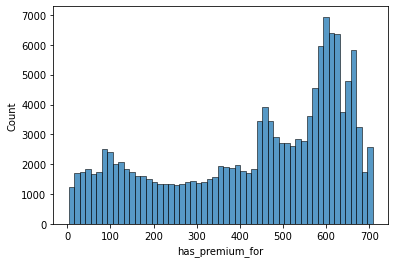

In [17]:
sns.histplot(data=train_dataset.has_premium_for)

Then we can generate some statistical number features for every client.

In [18]:
# Almost every number feature will be counted for last month, last 3 months and the whole dataset timespan. 

# It seems logical that the client who has a lot of purchases and buys frequently doesn't need
# a reminder to buy something and will do it by himself
train_dataset['total_transactions_count'] = train_purch_df.groupby(by='client_id').transaction_date.nunique()
train_dataset['transactions_count_last_month'] = train_purch_df.loc[(pd.to_datetime(train_purch_df.transaction_date) >= pd.Timestamp(train_purch_df.transaction_date.max())   
                                                                     - pd.DateOffset(months=1)).loc[lambda x: x == True].index].groupby(by='client_id').transaction_date.nunique().fillna(0)

train_dataset['transactions_count_last_3_months'] = train_purch_df.loc[(pd.to_datetime(train_purch_df.transaction_date) >= pd.Timestamp(train_purch_df.transaction_date.max()) 
                                                                     - pd.DateOffset(months=3)).loc[lambda x: x == True].index].groupby(by='client_id').transaction_date.nunique().fillna(0)

train_dataset['avg_transactions_in_a_month'] = train_dataset.total_transactions_count / (((train_purch_df.groupby(by='client_id').transaction_date.max() 
                                                                     - train_purch_df.groupby(by='client_id').transaction_date.min()) / np.timedelta64(1, 'M')).astype(int).fillna(0))

# since inf appears because of client has all his transactions in a single month
# we will imply he probably has only 1 transaction at all
train_dataset.avg_transactions_in_a_month.replace([np.inf, -np.inf], 1, inplace=True)

There are pretty much users who have average 10 transactions in a month which is equal to purchase every three days. Seems regular enough.

<AxesSubplot:xlabel='avg_transactions_in_a_month', ylabel='Count'>

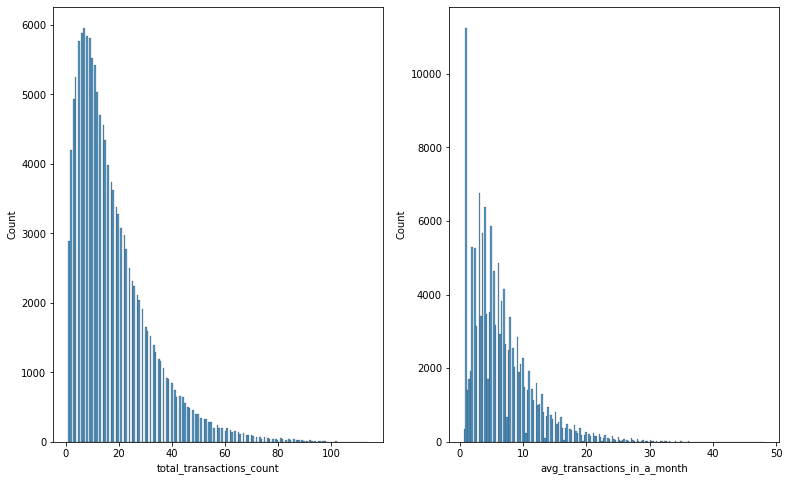

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(13, 8))
sns.histplot(train_dataset['total_transactions_count'], ax=ax[0])
sns.histplot(train_dataset['avg_transactions_in_a_month'], ax=ax[1])

In [20]:
# Maybe the client who spends more less money does it more or less regularly
# so let's retrieve statistics for the same timespans 
train_dataset['total_avg_checkout'] = train_purch_df.groupby(by='client_id').purchase_sum.mean()
train_dataset['total_max_checkout'] = train_purch_df.groupby(by='client_id').purchase_sum.max()
train_dataset['avg_checkout_last_month'] = train_purch_df.loc[(pd.to_datetime(train_purch_df.transaction_date) >= pd.Timestamp(train_purch_df.transaction_date.max()) 
                                                                      - pd.DateOffset(months=1)).loc[lambda x: x == True].index].groupby(by='client_id').purchase_sum.mean().fillna(0)
train_dataset['max_checkout_last_month'] = train_purch_df.loc[(pd.to_datetime(train_purch_df.transaction_date) >= pd.Timestamp(train_purch_df.transaction_date.max()) 
                                                                      - pd.DateOffset(months=1)).loc[lambda x: x == True].index].groupby(by='client_id').purchase_sum.max().fillna(0)
train_dataset['avg_checkout_last_3_months'] = train_purch_df.loc[(pd.to_datetime(train_purch_df.transaction_date) >= pd.Timestamp(train_purch_df.transaction_date.max()) 
                                                                      - pd.DateOffset(months=3)).loc[lambda x: x == True].index].groupby(by='client_id').purchase_sum.mean().fillna(0)
train_dataset['max_checkout_last_3_months'] = train_purch_df.loc[(pd.to_datetime(train_purch_df.transaction_date) >= pd.Timestamp(train_purch_df.transaction_date.max()) 
                                                                      - pd.DateOffset(months=3)).loc[lambda x: x == True].index].groupby(by='client_id').purchase_sum.max().fillna(0)

In [21]:
# getting and spending bonus points points for purchases probably will tell us something about the client
train_dataset['total_avg_reg_pts_recieved'] = train_purch_df.groupby(by='client_id').regular_points_received.mean()
train_dataset['total_avg_reg_pts_spent'] = train_purch_df.groupby(by='client_id').regular_points_spent.mean()
train_dataset['avg_reg_pts_recieved_last_month'] = train_purch_df.loc[(pd.to_datetime(train_purch_df.transaction_date) >= pd.Timestamp(train_purch_df.transaction_date.max()) 
                                                                      - pd.DateOffset(months=1)).loc[lambda x: x == True].index].groupby(by='client_id').regular_points_received.mean().fillna(0)
train_dataset['avg_reg_pts_spent_last_month'] = train_purch_df.loc[(pd.to_datetime(train_purch_df.transaction_date) >= pd.Timestamp(train_purch_df.transaction_date.max()) 
                                                                      - pd.DateOffset(months=1)).loc[lambda x: x == True].index].groupby(by='client_id').regular_points_spent.mean().fillna(0)
train_dataset['avg_reg_pts_recieved_last_3_months'] = train_purch_df.loc[(pd.to_datetime(train_purch_df.transaction_date) >= pd.Timestamp(train_purch_df.transaction_date.max()) 
                                                                      - pd.DateOffset(months=3)).loc[lambda x: x == True].index].groupby(by='client_id').regular_points_received.mean().fillna(0)
train_dataset['avg_reg_pts_spent_last_3_months'] = train_purch_df.loc[(pd.to_datetime(train_purch_df.transaction_date) >= pd.Timestamp(train_purch_df.transaction_date.max()) 
                                                                      - pd.DateOffset(months=3)).loc[lambda x: x == True].index].groupby(by='client_id').regular_points_spent.mean().fillna(0)

In [22]:
# It seems to be that so-called 'express points' are some kind of special bonus points
train_dataset['total_avg_exp_pts_recieved'] = train_purch_df.groupby(by='client_id').express_points_received.mean()
train_dataset['total_avg_exp_pts_spent'] = train_purch_df.groupby(by='client_id').express_points_received.mean()

We can see that most of the clients don't get them at all. Hence getting statistic for 1/3 months doesn't look reasonable.

In [23]:
train_dataset.total_avg_exp_pts_recieved.value_counts()

0.000000    137397
1.333333        12
0.909091        11
1.000000        11
0.625000        10
             ...  
1.504178         1
2.429907         1
1.023018         1
2.019231         1
2.258065         1
Name: total_avg_exp_pts_recieved, Length: 1669, dtype: int64

In [24]:
# Also we can get some information about product type: is it alcohol or own shop trademark. 
# Client who buys own shop production frequently can be regular customer for example 
train_dataset['alco_freq'] = train_purch_df.groupby(by='client_id').is_alcohol.sum() / train_purch_df.groupby(by='client_id').transaction_id.count()
train_dataset['own_prod_freq'] = train_purch_df.groupby(by='client_id').is_own_trademark.sum() / train_purch_df.groupby(by='client_id').transaction_id.count()

<AxesSubplot:xlabel='own_prod_freq', ylabel='Count'>

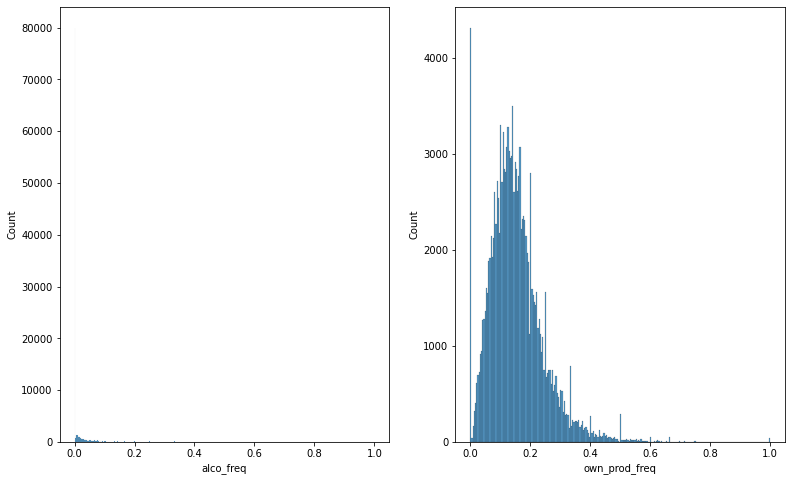

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(13, 8))
sns.histplot(train_dataset['alco_freq'], ax=ax[0])
sns.histplot(train_dataset['own_prod_freq'], ax=ax[1])

Looks like most of the clients buy own production not on purpose and almost nobody buys alco. So alcohool feature makes no sense, we will drop it in future.

In [26]:
# For overfitting purposes only :)
train_dataset['avg_mass'] = train_purch_df.groupby(by='client_id').netto.mean()

In [27]:
# Here we will collect some categorical features
# 'level_i' features seem to be products hierarchy and low-level (1, 2) 
# should give us some information about the client, same for product segment feature
train_dataset['fav_product_segment'] = train_purch_df.groupby(by='client_id').segment_id.agg(lambda x: pd.Series.mode(x).iat[0])
train_dataset['fav_store'] = train_purch_df.groupby(by='client_id').store_id.agg(lambda x: pd.Series.mode(x).iat[0])
train_dataset['fav_brand'] = train_purch_df.groupby(by='client_id').brand_id.agg(lambda x: pd.Series.mode(x).iat[0])
train_dataset['fav_level_1'] = train_purch_df.groupby(by='client_id').level_1.agg(lambda x: pd.Series.mode(x).iat[0])
train_dataset['fav_level_2'] = train_purch_df.groupby(by='client_id').level_2.agg(lambda x: pd.Series.mode(x).iat[0])
train_dataset['fav_level_3'] = train_purch_df.groupby(by='client_id').level_3.agg(lambda x: pd.Series.mode(x).iat[0])
train_dataset['fav_level_4'] = train_purch_df.groupby(by='client_id').level_4.agg(lambda x: pd.Series.mode(x).iat[0])

In [28]:
# it looks like there are too much unique categories and 80% of them are rare in level_4, 
# so it is likely we don't need it later
print(train_dataset['fav_level_4'].value_counts())
print(train_dataset['fav_level_4'].value_counts().loc[train_dataset['fav_level_4'].value_counts() > 100])

146717c1b2    27234
efbcf6d00c    10606
5330a84194     8118
47fc199714     7725
4d4b7e1f16     5645
              ...  
7208342de1        1
9a64f77354        1
7fd5d8cc76        1
82089899ce        1
cf71139b14        1
Name: fav_level_4, Length: 495, dtype: int64
146717c1b2    27234
efbcf6d00c    10606
5330a84194     8118
47fc199714     7725
4d4b7e1f16     5645
              ...  
f6148afbc0      105
303ab56ed3      101
bf375b7a11      101
8c4f3cdeef      101
33309c4145      101
Name: fav_level_4, Length: 113, dtype: int64


In [29]:
# for low-level hierarchy we can use category names as text features 
# train_dataset['level_1_cats'] = ' '.join(train_purch_df.level_1.value_counts().index.to_list())
# train_dataset['level_2_cats'] = ' '.join(train_purch_df.level_2.value_counts().index.to_list())

In [30]:
# Let's drop customers with too few purchases and customers with inadequate age for online-shop 
train_dataset.drop(index=train_dataset.loc[train_dataset.total_transactions_count < 5].index, inplace=True)
train_dataset.drop(index=train_dataset.loc[(train_dataset.age < 10) | (train_dataset.age > 100)].index, inplace=True)

In [31]:
len(train_df), len(train_dataset)

(140027, 122343)

Almost 20k of users do not buy enough to be in our dataset :)

### Test dataset

Same thing for test dataset

In [32]:
test_dataset['first_issue_time'] =  (pd.to_datetime(test_dataset['first_issue_date'])
     - pd.Timestamp('1970-01-01')) // pd.Timedelta('1D')

test_dataset['first_redeem_time'] =  (pd.to_datetime(test_dataset['first_redeem_date'])
     - pd.Timestamp('1970-01-01')) // pd.Timedelta('1D')

test_dataset['first_redeem_time'].fillna(0, inplace=True)

test_dataset['issue_redeem_delay'] = test_dataset['first_redeem_time'] \
    - test_dataset['first_issue_time']

test_dataset['avg_shopping_time'] = test_purch_df.groupby(by='client_id').transaction_time.mean()

test_dataset['has_premium_for'] = (pd.to_datetime(test_purch_df.transaction_datetime.max()) - pd.to_datetime(test_dataset.first_issue_date)) / pd.Timedelta('1D')

In [33]:
test_dataset['total_transactions_count'] = test_purch_df.groupby(by='client_id').transaction_id.nunique()
test_dataset['transactions_count_last_month'] = test_purch_df.loc[(pd.to_datetime(test_purch_df.transaction_date) >= pd.Timestamp(test_purch_df.transaction_date.max()) - pd.DateOffset(months=1)).loc[lambda x: x == True].index].groupby(by='client_id').transaction_date.nunique().fillna(0)

test_dataset['avg_transactions_in_a_month'] = test_dataset.total_transactions_count / (((test_purch_df.groupby(by='client_id').transaction_date.max() - test_purch_df.groupby(by='client_id').transaction_date.min()) / np.timedelta64(1, 'M')).astype(int).fillna(0))

test_dataset['transactions_count_last_3_months'] = test_purch_df.loc[(pd.to_datetime(test_purch_df.transaction_date) >= pd.Timestamp(test_purch_df.transaction_date.max()) 
                                                                      - pd.DateOffset(months=3)).loc[lambda x: x == True].index].groupby(by='client_id').transaction_date.nunique().fillna(0)

test_dataset['total_avg_checkout'] = test_purch_df.groupby(by='client_id').purchase_sum.mean()
test_dataset['total_max_checkout'] = test_purch_df.groupby(by='client_id').purchase_sum.max()
test_dataset['avg_checkout_last_month'] = test_purch_df.loc[(pd.to_datetime(test_purch_df.transaction_date) >= pd.Timestamp(test_purch_df.transaction_date.max()) 
                                                                      - pd.DateOffset(months=1)).loc[lambda x: x == True].index].groupby(by='client_id').purchase_sum.mean().fillna(0)
test_dataset['max_checkout_last_month'] = test_purch_df.loc[(pd.to_datetime(test_purch_df.transaction_date) >= pd.Timestamp(test_purch_df.transaction_date.max()) 
                                                                      - pd.DateOffset(months=1)).loc[lambda x: x == True].index].groupby(by='client_id').purchase_sum.max().fillna(0)
test_dataset['avg_checkout_last_3_months'] = test_purch_df.loc[(pd.to_datetime(test_purch_df.transaction_date) >= pd.Timestamp(test_purch_df.transaction_date.max()) 
                                                                      - pd.DateOffset(months=3)).loc[lambda x: x == True].index].groupby(by='client_id').purchase_sum.mean().fillna(0)
test_dataset['max_checkout_last_3_months'] = test_purch_df.loc[(pd.to_datetime(test_purch_df.transaction_date) >= pd.Timestamp(test_purch_df.transaction_date.max()) 
                                                                      - pd.DateOffset(months=3)).loc[lambda x: x == True].index].groupby(by='client_id').purchase_sum.max().fillna(0)


test_dataset['total_avg_reg_pts_recieved'] = test_purch_df.groupby(by='client_id').regular_points_received.mean()
test_dataset['total_avg_reg_pts_spent'] = test_purch_df.groupby(by='client_id').regular_points_spent.mean()
test_dataset['avg_reg_pts_recieved_last_month'] = test_purch_df.loc[(pd.to_datetime(test_purch_df.transaction_date) >= pd.Timestamp(test_purch_df.transaction_date.max()) 
                                                                      - pd.DateOffset(months=1)).loc[lambda x: x == True].index].groupby(by='client_id').regular_points_received.mean().fillna(0)
test_dataset['avg_reg_pts_spent_last_month'] = test_purch_df.loc[(pd.to_datetime(test_purch_df.transaction_date) >= pd.Timestamp(test_purch_df.transaction_date.max()) 
                                                                      - pd.DateOffset(months=1)).loc[lambda x: x == True].index].groupby(by='client_id').regular_points_spent.mean().fillna(0)
test_dataset['avg_reg_pts_recieved_last_3_months'] = test_purch_df.loc[(pd.to_datetime(test_purch_df.transaction_date) >= pd.Timestamp(test_purch_df.transaction_date.max()) 
                                                                      - pd.DateOffset(months=3)).loc[lambda x: x == True].index].groupby(by='client_id').regular_points_received.mean().fillna(0)
test_dataset['avg_reg_pts_spent_last_3_months'] = test_purch_df.loc[(pd.to_datetime(test_purch_df.transaction_date) >= pd.Timestamp(test_purch_df.transaction_date.max()) 
                                                                      - pd.DateOffset(months=3)).loc[lambda x: x == True].index].groupby(by='client_id').regular_points_spent.mean().fillna(0)

test_dataset['total_avg_exp_pts_recieved'] = test_purch_df.groupby(by='client_id').express_points_received.mean()
test_dataset['total_avg_exp_pts_spent'] = test_purch_df.groupby(by='client_id').express_points_received.mean()

test_dataset['alco_freq'] = test_purch_df.groupby(by='client_id').is_alcohol.sum() / test_purch_df.groupby(by='client_id').transaction_id.count()
test_dataset['own_prod_freq'] = test_purch_df.groupby(by='client_id').is_own_trademark.sum() / test_purch_df.groupby(by='client_id').transaction_id.count()

test_dataset['avg_mass'] = test_purch_df.groupby(by='client_id').netto.mean()

In [34]:
test_dataset['fav_product_segment'] = test_purch_df.groupby(by='client_id').segment_id.agg(lambda x: pd.Series.mode(x).iat[0])
test_dataset['fav_store'] = test_purch_df.groupby(by='client_id').store_id.agg(lambda x: pd.Series.mode(x).iat[0])
test_dataset['fav_brand'] = test_purch_df.groupby(by='client_id').brand_id.agg(lambda x: pd.Series.mode(x).iat[0])
test_dataset['fav_level_1'] = test_purch_df.groupby(by='client_id').level_1.agg(lambda x: pd.Series.mode(x).iat[0])
test_dataset['fav_level_2'] = test_purch_df.groupby(by='client_id').level_2.agg(lambda x: pd.Series.mode(x).iat[0])
test_dataset['fav_level_3'] = test_purch_df.groupby(by='client_id').level_3.agg(lambda x: pd.Series.mode(x).iat[0])
test_dataset['fav_level_4'] = test_purch_df.groupby(by='client_id').level_4.agg(lambda x: pd.Series.mode(x).iat[0])

In [35]:
# test_dataset['level_1_cats'] = ' '.join(test_purch_df.level_1.value_counts().index.to_list())
# test_dataset['level_2_cats'] = ' '.join(test_purch_df.level_2.value_counts().index.to_list())

## model

In [36]:
# let's take another look at what we got
train_dataset

,target,first_issue_date,first_redeem_date,age,gender,first_issue_time,first_redeem_time,issue_redeem_delay,avg_shopping_time,has_premium_for,...,alco_freq,own_prod_freq,avg_mass,fav_product_segment,fav_store,fav_brand,fav_level_1,fav_level_2,fav_level_3,fav_level_4
client_id,,,,,,,,,,,,,,,,,,,,,
ad6561e2d8,1,2017-12-03 17:33:51,2018-05-23 18:59:01,50,F,17503,17674.0,171.0,50058.417476,470.240012,...,0.004854,0.082524,0.507626,1,658cf09cd4,4da2dc345f,c3d3a8e8c6,ad2b2e17d2,ca69ed9de2,5330a84194
b58fadcab6,1,2017-11-02 21:17:45,2018-09-15 21:02:16,36,U,17472,17789.0,317.0,50923.516129,501.084525,...,0.000000,0.225806,0.463722,92,251d468760,d96cce0e17,e344ab2e71,14d373dff5,39532a0f6f,16341715da
e99e6fabb9,1,2018-05-16 10:21:20,2018-05-30 20:49:24,79,F,17667,17681.0,14.0,33489.872340,306.540370,...,0.000000,0.042553,0.337170,85,b0243e224b,9206024c8f,e344ab2e71,ad2b2e17d2,ca69ed9de2,399018cdea
27fb6f8520,1,2017-07-17 19:36:28,2017-12-15 10:05:25,34,F,17364,17515.0,151.0,42098.590000,609.154861,...,0.000000,0.200000,0.663480,223,62affcee52,4da2dc345f,e344ab2e71,ed2ad1797c,3e810ee449,dcf1c1e6de
5e83b02b85,1,2018-08-01 13:27:50,2019-01-11 18:01:43,35,U,17744,17907.0,163.0,48954.194444,229.410856,...,0.092593,0.219136,0.449222,18,822f9361dd,037a833d06,e344ab2e71,14d373dff5,334b74af37,146717c1b2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f899169fa7,0,2018-11-11 11:35:46,2018-12-30 17:40:16,62,M,17846,17895.0,49.0,42459.534483,127.488681,...,0.000000,0.051724,0.448000,230,30f30e4cd1,253c5a0ce4,e344ab2e71,fb3d79909e,b4f6ca38b2,efbcf6d00c
f634deea4e,0,2018-02-04 13:51:32,2018-03-12 17:41:42,35,U,17566,17602.0,36.0,54062.895288,407.394398,...,0.005236,0.188482,0.307597,313,f90f538452,fdde33576a,e344ab2e71,ed2ad1797c,bd7a98e9af,c0a825c891
16cb4f99b0,0,2018-02-23 10:02:33,2019-05-31 17:37:36,50,F,17585,18047.0,462.0,48856.950000,388.553414,...,0.000000,0.050000,0.376400,9,11700bbcda,8cad03a8ee,e344ab2e71,703f4b6eb0,f4613d272f,47fc199714


In [37]:
# During numerous experiments bad features were found. 
# As expected, express points and alco_freq with enormous quantity of zero elements showed themselves badly,
# fav_level_4 is contradictory feature but it was dropped because of its unstability. 
X_train_val = train_dataset.drop(columns=['target', 'first_issue_date', 'first_redeem_date', 'alco_freq',
                                          'fav_level_4', 'total_avg_exp_pts_recieved', 'total_avg_reg_pts_recieved',
                                         'total_avg_exp_pts_spent', 'avg_mass'])

cat_features = ['gender', 'fav_store', 'fav_brand', 'fav_product_segment', 'fav_level_1', 'fav_level_2', 'fav_level_3']
# text_features = ['level_1_cats', 'level_2_cats']

y = train_dataset.target

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y, random_state=194, test_size = 0.3)

X_test = test_dataset.drop(columns=['first_issue_date', 'first_redeem_date', 'alco_freq',
                                    'fav_level_4', 'total_avg_exp_pts_recieved', 'total_avg_reg_pts_recieved',
                                   'total_avg_exp_pts_spent', 'avg_mass'])

In [38]:
# During numerous experiments bad features were found. 
# As expected, express points and alco_freq with enormous quantity of zero elements showed themselves badly,
# fav_level_4 is contradictory feature but it was dropped because of its unstability. 
X_train_val = train_dataset.drop(columns=['target', 'first_issue_date', 'first_redeem_date', 'alco_freq',
                                          'fav_level_4', 'total_avg_exp_pts_recieved', 'total_avg_reg_pts_recieved',
                                         'total_avg_exp_pts_spent', 'avg_mass'])

cat_features = ['gender', 'fav_store', 'fav_brand', 'fav_product_segment', 'fav_level_1', 'fav_level_2', 'fav_level_3']
# text_features = ['level_1_cats', 'level_2_cats']

y = train_dataset.target

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y, random_state=194, test_size = 0.3)

X_test = test_dataset.drop(columns=['first_issue_date', 'first_redeem_date', 'alco_freq',
                                    'fav_level_4', 'total_avg_exp_pts_recieved', 'total_avg_reg_pts_recieved',
                                   'total_avg_exp_pts_spent', 'avg_mass'])

In [39]:
'''
During numerous experiments bad features were found. 
As expected, express points and alco_freq with enormous quantity of zero elements showed themselves badly,
fav_level_4 is contradictory feature but it was dropped because of its unstability
'''

X_train_val = train_dataset.drop(columns=['target', 'first_issue_date', 'first_redeem_date', 'alco_freq',
                                          'fav_level_4', 'total_avg_exp_pts_recieved', 'total_avg_reg_pts_recieved',
                                         'total_avg_exp_pts_spent', 'avg_mass'])
cat_features = ['gender', 'fav_store', 'fav_brand', 'fav_product_segment', 'fav_level_1', 'fav_level_2', 'fav_level_3']


# These cats are not used because catboost.sum_models does not work with text features.
# and that they do not give significant improvement on a single model, so free kittens here.
# text_features = ['level_1_cats', 'level_2_cats']


y = train_dataset.target

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y, random_state=194, test_size = 0.3)

X_test = test_dataset.drop(columns=['first_issue_date', 'first_redeem_date', 'alco_freq',
                                    'fav_level_4', 'total_avg_exp_pts_recieved', 'total_avg_reg_pts_recieved',
                                   'total_avg_exp_pts_spent', 'avg_mass'])

In [40]:
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
val_pool = Pool(data=X_val, label=y_val, cat_features=cat_features)
test_pool = Pool(data=X_test, cat_features=cat_features)

In [41]:
'''
Since results are very unstable because of random seed hesitation 
an ensemble of 8 catboost classifiers is used.
Model is also very dependent on train_test_split random seed 
and validation results do not correlate with test results well. 
Cross-validation looks like pretty logical solution here, worth trying in future.

Making separate validation and test datasets gave nothing good. Train dataset had 80k customers
with leaderboard_test dataset of 60k clients, plus test and leaderboard_test scores didn't correlate well.  
'''
clsf = []
for i in range(8):
#    Regularization and RSM are pretty rough.
#    Model likes to overfit because of plenty of time features converted to a huge amount of different numbers.
    model = CatBoostClassifier(iterations=180, learning_rate=0.03, l2_leaf_reg=20, model_size_reg=20, rsm=0.6, 
                                                                eval_metric='NormalizedGini', random_seed=(i)*13)
    
    print(f'model {i+1}')
    model.fit(train_pool, 
              eval_set=val_pool)
    clsf.append(model)

model 1
0:	test: 0.0450640	best: 0.0450640 (0)	total: 131ms	remaining: 23.4s
1:	test: 0.0482827	best: 0.0482827 (1)	total: 193ms	remaining: 17.2s
2:	test: 0.0501720	best: 0.0501720 (2)	total: 247ms	remaining: 14.5s
3:	test: 0.0506868	best: 0.0506868 (3)	total: 300ms	remaining: 13.2s
4:	test: 0.0509020	best: 0.0509020 (4)	total: 366ms	remaining: 12.8s
5:	test: 0.0502732	best: 0.0509020 (4)	total: 418ms	remaining: 12.1s
6:	test: 0.0503895	best: 0.0509020 (4)	total: 460ms	remaining: 11.4s
7:	test: 0.0497773	best: 0.0509020 (4)	total: 509ms	remaining: 10.9s
8:	test: 0.0504898	best: 0.0509020 (4)	total: 558ms	remaining: 10.6s
9:	test: 0.0491793	best: 0.0509020 (4)	total: 608ms	remaining: 10.3s
10:	test: 0.0502316	best: 0.0509020 (4)	total: 656ms	remaining: 10.1s
11:	test: 0.0504678	best: 0.0509020 (4)	total: 703ms	remaining: 9.84s
12:	test: 0.0513280	best: 0.0513280 (12)	total: 751ms	remaining: 9.64s
13:	test: 0.0516724	best: 0.0516724 (13)	total: 778ms	remaining: 9.23s
14:	test: 0.0545243	

In [42]:
# Create ensemble
clsf_avg = catboost.sum_models(clsf, weights=[1.0/len(clsf)] * len(clsf))

In [43]:
# some numbers
val_preds = clsf_avg.predict(val_pool)
gini_score(y_val, val_preds)

0.05618509755280976

In [44]:
'''
Here we can see that more than a half of the result is given by first redeem time. Looks like serious overfitting 
and inapplicable in production, but we try to beat the highscore in the Kaggle competition so we use it anyway.

Looks like some categorical features in the bottom of the table have no influence on the result, 
but both validation and test drop by 0.005 Gini without them which is very significant in  of Kaggle competition.
'''
clsf_avg.get_feature_importance(prettified=True)

,Feature Id,Importances
0,first_redeem_time,55.547082
1,age,3.818547
2,gender,2.600220
3,avg_shopping_time,2.340322
4,fav_level_2,2.097440
5,first_issue_time,1.944349
6,total_avg_checkout,1.904732
7,has_premium_for,1.885738
8,issue_redeem_delay,1.865341
9,avg_reg_pts_recieved_last_month,1.789814


## get predictions

In [45]:
preds = clsf_avg.predict(test_pool)

In [46]:
test_df['pred'] = preds

In [47]:
test_df.to_csv('submission.csv', index=False)

## Training without 'first_redeem_time'

In [48]:
# same features are dropped
# feature pre-engineering was done here for main solution because of adequate feature importance distribution
X_train_val_1 = train_dataset.drop(columns=['target', 'first_issue_date', 'first_redeem_date', 'first_redeem_time',
                                            'avg_mass', 'first_issue_time', 'fav_level_4'])

cat_features = ['gender', 'fav_store', 'fav_brand', 'fav_product_segment', 'fav_level_1', 'fav_level_2', 'fav_level_3']
# text_features = ['level_1_cats', 'level_2_cats']

y = train_dataset.target

X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(X_train_val_1, y, random_state=194, test_size = 0.3)

X_test_1 = test_dataset.drop(columns=['first_issue_date', 'first_redeem_date', 'first_redeem_time',
                                      'avg_mass', 'first_issue_time', 'fav_level_4'])

In [49]:
train_pool_1 = Pool(data=X_train_1, label=y_train_1, cat_features=cat_features)
val_pool_1 = Pool(data=X_val_1, label=y_val_1, cat_features=cat_features)
test_pool_1 = Pool(data=X_test_1, cat_features=cat_features)

In [50]:
clsf_1 = []
for i in range(8):
    model = CatBoostClassifier(iterations=80, learning_rate=0.03, l2_leaf_reg=20, model_size_reg=20, rsm=0.6, 
                                                                eval_metric='NormalizedGini', random_seed=(i)*13)
    
    print(f'model {i+1}')
    model.fit(train_pool_1, 
              eval_set=val_pool_1)
    clsf_1.append(model)
clsf_avg_1 = catboost.sum_models(clsf_1, weights=[1.0/len(clsf)] * len(clsf))

model 1
0:	test: 0.0131818	best: 0.0131818 (0)	total: 67.1ms	remaining: 5.3s
1:	test: 0.0209370	best: 0.0209370 (1)	total: 117ms	remaining: 4.56s
2:	test: 0.0207193	best: 0.0209370 (1)	total: 166ms	remaining: 4.25s
3:	test: 0.0182687	best: 0.0209370 (1)	total: 212ms	remaining: 4.03s
4:	test: 0.0204547	best: 0.0209370 (1)	total: 267ms	remaining: 4.01s
5:	test: 0.0217775	best: 0.0217775 (5)	total: 321ms	remaining: 3.96s
6:	test: 0.0227569	best: 0.0227569 (6)	total: 372ms	remaining: 3.88s
7:	test: 0.0227070	best: 0.0227569 (6)	total: 421ms	remaining: 3.79s
8:	test: 0.0219783	best: 0.0227569 (6)	total: 468ms	remaining: 3.69s
9:	test: 0.0221481	best: 0.0227569 (6)	total: 518ms	remaining: 3.63s
10:	test: 0.0232365	best: 0.0232365 (10)	total: 561ms	remaining: 3.52s
11:	test: 0.0248573	best: 0.0248573 (11)	total: 610ms	remaining: 3.46s
12:	test: 0.0242415	best: 0.0248573 (11)	total: 659ms	remaining: 3.39s
13:	test: 0.0242483	best: 0.0248573 (11)	total: 711ms	remaining: 3.35s
14:	test: 0.024141

In [51]:
val_preds_1 = clsf_avg_1.predict(val_pool_1)
gini_score(y_val_1, val_preds_1)

0.029488951248664463

In [52]:
clsf_avg_1.get_feature_importance(prettified=True)

,Feature Id,Importances
0,age,8.675606
1,has_premium_for,7.182532
2,avg_shopping_time,5.424507
3,gender,5.247012
4,issue_redeem_delay,4.998620
5,max_checkout_last_3_months,4.228675
6,total_avg_checkout,3.965794
7,avg_checkout_last_month,3.930595
8,max_checkout_last_month,3.670147
9,total_avg_reg_pts_spent,3.668016
